In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

import torch.optim as optim

from datetime import datetime as dt

import matplotlib.pyplot as plt

In [32]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [2]:
g1 = pd.read_csv('data/G(배) 수위#1 (F_CV).csv', header=None)
g1.columns = ['date', 'height1']

g2 = pd.read_csv('data/G(배) 수위#2 (F_CV).csv', header=None)
g2.columns = ['date', 'height2']

In [35]:
merged_df = pd.merge(g1, g2, on='date')
merged_df.head(), merged_df.describe()

(                  date  height1  height2
 0  2018-01-01 00:01:00    3.407    3.416
 1  2018-01-01 00:02:00    3.407    3.416
 2  2018-01-01 00:03:00    3.407    3.416
 3  2018-01-01 00:04:00    3.397    3.417
 4  2018-01-01 00:05:00    3.397    3.416,
           height1     height2
 count 2624769.000 2624769.000
 mean        3.491       3.507
 std         0.328       0.317
 min         0.000       0.000
 25%         3.355       3.366
 50%         3.527       3.543
 75%         3.696       3.712
 max         4.100       4.096)

In [34]:
merged_df['height1'] < 0, merged_df['height2'] < 0

(0          False
 1          False
 2          False
 3          False
 4          False
            ...  
 2624764    False
 2624765    False
 2624766    False
 2624767    False
 2624768    False
 Name: height1, Length: 2624769, dtype: bool,
 0          False
 1          False
 2          False
 3          False
 4          False
            ...  
 2624764    False
 2624765    False
 2624766    False
 2624767    False
 2624768    False
 Name: height2, Length: 2624769, dtype: bool)

In [5]:
merged_df.isna().sum()

date       0
height1    0
height2    0
dtype: int64

In [36]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df.set_index('date', inplace=True)

In [37]:
merged_df = merged_df.resample('h').mean()
merged_df.head(), merged_df.tail()

(                     height1  height2
 date                                 
 2018-01-01 00:00:00    3.348    3.360
 2018-01-01 01:00:00    3.235    3.246
 2018-01-01 02:00:00    3.262    3.274
 2018-01-01 03:00:00    3.341    3.353
 2018-01-01 04:00:00    3.419    3.431,
                      height1  height2
 date                                 
 2022-12-31 19:00:00    3.351    3.363
 2022-12-31 20:00:00    3.388    3.401
 2022-12-31 21:00:00    3.393    3.407
 2022-12-31 22:00:00    3.359    3.373
 2022-12-31 23:00:00    3.348    3.366)

In [8]:
type(merged_df)

pandas.core.frame.DataFrame

In [9]:
merged_df['height'] = merged_df[['height1', 'height2']].mean(axis=1)
merged_df = merged_df[['height']]
print(merged_df)

                       height
date                         
2018-01-01 00:00:00  3.354141
2018-01-01 01:00:00  3.240187
2018-01-01 02:00:00  3.267999
2018-01-01 03:00:00  3.346774
2018-01-01 04:00:00  3.424741
...                       ...
2022-12-31 19:00:00  3.357266
2022-12-31 20:00:00  3.394401
2022-12-31 21:00:00  3.399968
2022-12-31 22:00:00  3.366247
2022-12-31 23:00:00  3.357088

[43824 rows x 1 columns]


In [10]:
merged_df.isna().sum()

height    63
dtype: int64

In [11]:
merged_df.describe()

,height
count,43761.000000
mean,3.498830
std,0.305143
min,0.000000
25%,3.358453
50%,3.533743
75%,3.701384
max,4.090788


In [12]:
# 선형식 보간법
# merged_df['height'].interpolate(method='linear', inplace=True)

# 다항식 보간법
merged_df['height'] = merged_df['height'].interpolate(method='polynomial', order=2)

In [13]:
train_size = 0.7
val_size = 0.15
test_size = 0.15

train_split = int(train_size * len(merged_df))
val_split = int((train_size + val_size) * len(merged_df))

In [44]:
train_data = merged_df[:train_split]
val_data = merged_df[train_split:val_split]
test_data = merged_df[val_split:]

train_data[:-5], val_data[:-5], test_data[:-5]

(                     height1  height2
 date                                 
 2021-07-01 23:00:00    3.876    3.886
 2021-07-02 00:00:00    3.803    3.814
 2021-07-02 01:00:00    3.699    3.710
 2021-07-02 02:00:00    3.599    3.610
 2021-07-02 03:00:00    3.500    3.512,
                      height1  height2
 date                                 
 2022-04-01 21:00:00    3.201    3.214
 2022-04-01 22:00:00    3.187    3.201
 2022-04-01 23:00:00    3.239    3.250
 2022-04-02 00:00:00    3.320    3.332
 2022-04-02 01:00:00    3.410    3.422)

In [39]:
# NaN 값 확인
print("NaN values in train_data before scaling:", train_data.isna().sum().sum())
print("NaN values in val_data before scaling:", val_data.isna().sum().sum())
print("NaN values in test_data before scaling:", test_data.isna().sum().sum())

NaN values in train_data before scaling: 126
NaN values in val_data before scaling: 0
NaN values in test_data before scaling: 0


In [16]:
scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train_data)

scaled_val = scaler.transform(val_data)

scaled_test = scaler.transform(test_data)

In [17]:
print(np.isnan(scaled_train).sum())  # NaN 값의 수 출력
print(np.isnan(scaled_val).sum())
print(np.isnan(scaled_test).sum())

0
0
0


In [18]:
def create_sequences(df, target_data, seq_length):
    xs, ys = [], []
    for i in range(len(df) - seq_length):
        x = df[i:i+seq_length]
        y = target_data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 24
X_train, y_train = create_sequences(scaled_train, scaled_train, seq_length)
X_val, y_val = create_sequences(scaled_val, scaled_val, seq_length)
X_test, y_test = create_sequences(scaled_test, scaled_test, seq_length)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(30652, 24, 1) (6550, 24, 1) (6550, 24, 1)
(30652, 1) (6550, 1) (6550, 1)


In [19]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [20]:
# NaN 값 확인
print("NaN values in X_train tensor:", torch.isnan(X_train).sum().item())
print("NaN values in y_train tensor:", torch.isnan(y_train).sum().item())

NaN values in X_train tensor: 0
NaN values in y_train tensor: 0


In [21]:
class HeightPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(HeightPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size = 2, stride = 1) # 1D CNN 레이어 추가
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden, # 기억하고 있는 정보량
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self): # LSTM 레이어 은닉 상태 초기화
        self.hidden = ( # 모델의 초기화나 새로운 데이터 시퀀스 처리 전 호출
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden)
        )

    def forward(self, sequences):
        sequences = self.c1(sequences.view(len(sequences), 1, -1))
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len-1, -1), # LSTM 출력 저장(lstm_out)한 크기
            self.hidden # 함께, CNN 출력을 LSTM에 입력하여 시퀀스 처리
        )
        last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1] # (len(sequences), self.n_hidden)
        y_pred = self.linear(last_time_step)
        return y_pred # (LEN(sequences), 1)

In [22]:
model = HeightPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)

In [23]:
print(model)

HeightPredictor(
  (c1): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
  (lstm): LSTM(1, 4)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


In [24]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=20, verbose = 5, patience = 10):
    loss_fn = torch.nn.MSELoss() # verbose : 출력할 때마다 보고할 에포크의 간격 # patience : 조기종료 결정
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    train_hist = []
    val_hist = []
    
    for t in tqdm(range(num_epochs)):

        model.train()
        epoch_loss = 0

        for idx, seq in enumerate(train_data): # 

            model.reset_hidden_state() # sample 별 hidden state reset을 해줘야 > 기억하고 있는 정보 reset

            # train loss
            seq = torch.unsqueeze(seq, 0) # unsqueeze(input, dim) : 원본 데이터 dim 위치에 차원 추가하기
            # print(seq) 원본 데이터 프레임은 모두 nan이 없었는데 둘을 합치고 나서 nan이 발생
            y_pred = model(seq)
            # print(f'y_pred: {y_pred}, train_labels[idx]: {train_labels[idx]}')
            
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step() # 가중치 업데이트

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            model.eval()
            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() #seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0) # unsqueeze(input, dim) : 원본 데이터 dim 위치에 차원 추가하기
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인 # 검증용 손실값(validation loss)을 patience번째 epoch마다 patience만큼의 이전 손실값과 비교해 줄어들지 않으면 학습을 종료 시킬 때 사용하는 인자
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [25]:
model = HeightPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=20,
    verbose=5,
    patience=10
)

c:\Users\user\anaconda\envs\py3_11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  5%|▌         | 1/20 [00:54<17:08, 54.11s/it]

Epoch 0 train loss: 0.003130731997832352 val loss: 0.004670797847211361


 30%|███       | 6/20 [05:33<12:55, 55.43s/it]

Epoch 5 train loss: 0.0009514174604345427 val loss: 0.0051260897889733315


 55%|█████▌    | 11/20 [10:09<08:16, 55.19s/it]

Epoch 10 train loss: 0.0007860339496335495 val loss: 0.003778348909690976


 80%|████████  | 16/20 [14:52<03:46, 56.61s/it]

Epoch 15 train loss: 0.0007749248266500151 val loss: 0.004177202936261892


100%|██████████| 20/20 [18:42<00:00, 56.13s/it]


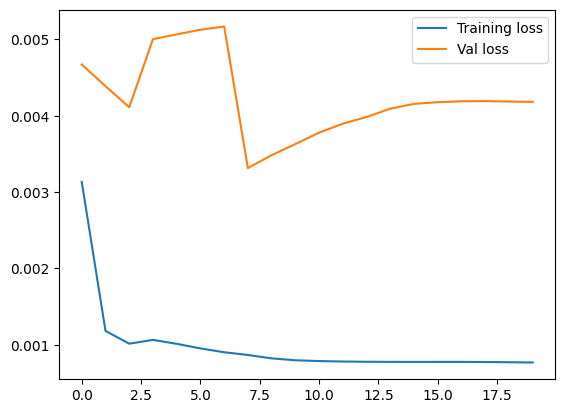

In [26]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

In [27]:
pred_dataset = X_test

model.eval()
with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

In [28]:
preds = np.array(preds)
preds = preds.reshape(-1, 1)

In [29]:
actual = scaler.inverse_transform(y_test)
predicted = scaler.inverse_transform(preds)

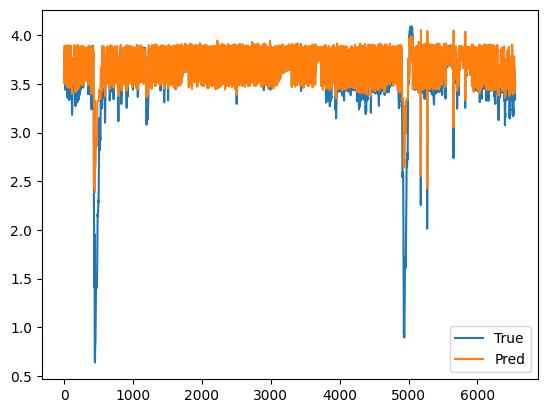

In [30]:
plt.plot(actual, label = 'True')
plt.plot(predicted, label = 'Pred')
plt.legend()
plt.show()

In [31]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE:", rmse)

RMSE: 0.055756576211214486
